In [1]:
"""
todo 
inspect spacing to choose a single best size
resample data and label into this size

extract bbox(center and size) from mask (refer to glia net for implmentation)
"""
import os
from glob import glob
import SimpleITK as sitk
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def apply_window(img, min_hu=-1000, max_hu=200):
    img = (img-min_hu)/(max_hu-min_hu)
    img[img>1.] = 1.
    img[img<0.] = 0.
    return img
def show(img):
    plt.close()
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='gray')
    plt.show()

In [2]:
train_im_dir = "/work/vig/Datasets/aneurysm/internal_train/og_0.4"
test_im_dir = "/work/vig/Datasets/aneurysm/internal_test"
train_mask_dir = "/work/vig/Datasets/aneurysm/internal_label_train"
test_mask_dir = "/work/vig/Datasets/aneurysm/internal_label_test"

train_im_files = sorted(list(glob(f"{train_im_dir}/*")))
val_im_files = sorted(list(glob(f"{test_im_dir}/*")))
train_mask_files = sorted(list(glob(f"{train_mask_dir}/*")))
test_mask_files = sorted(list(glob(f"{test_mask_dir}/*")))
len(train_im_files), len(val_im_files), len(train_mask_files), len(test_mask_files)

(1186, 152, 1186, 152)

In [5]:

# image = sitk.ReadImage()
train_im_files[0], train_mask_files[0]

('/work/vig/Datasets/aneurysm/internal_train/Tr0001.nii.gz',
 '/work/vig/Datasets/aneurysm/internal_label_train/Tr0001.nii.gz')

In [5]:
def norm(x, min_x=0., max_x=800.):
    x[x > max_x] = max_x
    x[x < min_x] = min_x
    x = (x - min_x) / (max_x - min_x)
    return x

In [18]:
import nibabel as nib
start = time.perf_counter()
img = nib.load(train_im_files[200])

    # Get the data as a numpy array
img_data = img.get_fdata()
print(time.perf_counter()-start)


8.006784299388528


In [19]:
import time
start = time.perf_counter()
mask_header = sitk.ReadImage(train_im_files[200])
mask = sitk.GetArrayFromImage(mask_header)
print(time.perf_counter()-start)
start = time.perf_counter()
mask = mask.astype(np.float32)
mask = norm(mask)
mask.max(), mask.min(), mask.shape

5.665560295805335


(1.0, 0.0, (920, 712, 712))

In [9]:
mask_header.GetSpacing()

(0.4296875, 0.4296875, 0.4000244140625)

In [11]:
train_space = []
for x in tqdm(test_mask_files):
    train_space.append(np.array(sitk.ReadImage(x).GetSpacing()))

100%|██████████| 152/152 [00:16<00:00,  9.27it/s]


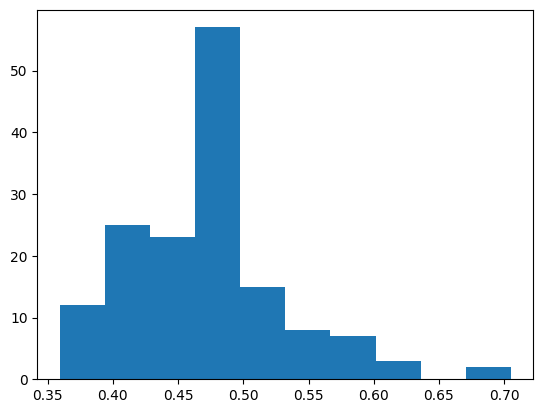

In [14]:
xy_s = [x[0] for x in train_space]
plt.hist(xy_s)
plt.show()

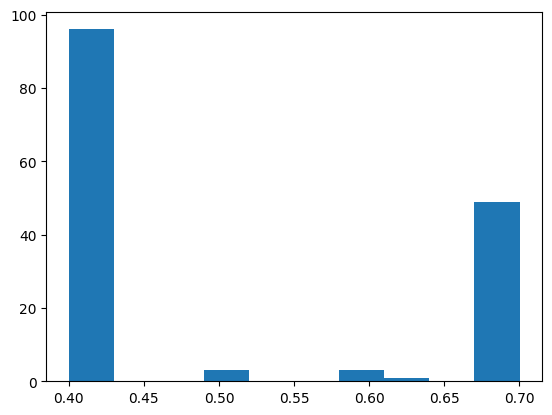

In [15]:
z_s = [x[2] for x in train_space]
plt.hist(z_s)
plt.show()

In [16]:
test_space = []
for x in tqdm(train_mask_files):
    test_space.append(np.array(sitk.ReadImage(x).GetSpacing()))

100%|██████████| 1186/1186 [02:01<00:00,  9.73it/s]


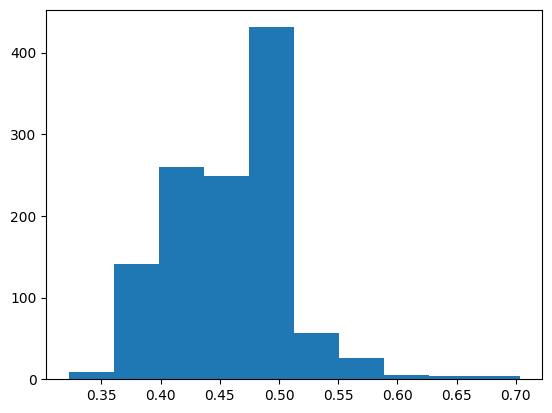

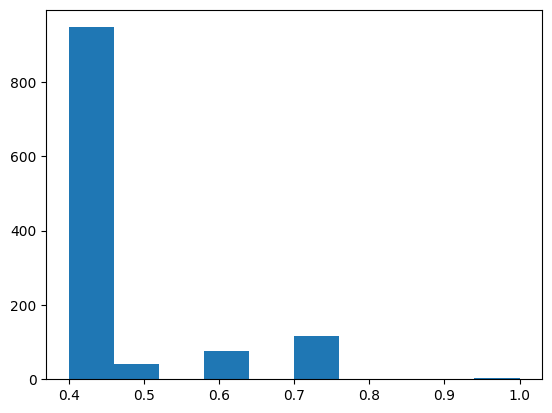

In [18]:
xy_s = [x[0] for x in test_space]
plt.hist(xy_s)
plt.show()
z_s = [x[2] for x in test_space]
plt.hist(z_s)
plt.show()

## resample data

In [17]:
def resample_simg(itkimage:sitk.Image, newSpacing=(1.0, 1.0, 1.0), label=False)->sitk.Image:
    """
    image resize withe sitk resampleImageFilter
    :param itkimage:
    :param newSpacing:such as [1,1,1]
    :param resamplemethod:
    :return:
    """
    newSpacing = np.array(newSpacing, float)
    originSpcaing = itkimage.GetSpacing()
    resampler = sitk.ResampleImageFilter()
    originSize = itkimage.GetSize()
    factor = newSpacing / originSpcaing
    newSize = originSize / factor
    newSize = newSize.astype(np.int)
    resampler.SetReferenceImage(itkimage)
    resampler.SetOutputSpacing(newSpacing.tolist())
    resampler.SetSize(newSize.tolist())
    resampler.SetTransform(sitk.Transform(3, sitk.sitkIdentity))
    if label:
        resamplemethod=sitk.sitkNearestNeighbor
    else:
        resamplemethod=sitk.sitkLinear
    resampler.SetInterpolator(resamplemethod)
    itkimgResampled = resampler.Execute(itkimage)
    return itkimgResampled

In [19]:
mask.shape

(392, 512, 512)

In [20]:
new_mask_data = resample_simg(mask_header, (0.4,0.4,0.4))

/tmp/ipykernel_56757/1572345796.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  newSize = newSize.astype(np.int)


In [21]:
new_mask = sitk.GetArrayFromImage(new_mask_data)
new_mask.shape

(392, 550, 550)

In [ ]:
new_mask.max

In [24]:
sitk.WriteImage(new_mask_data, "/work/vig/Datasets/aneurysm/internal_train/og_0.4_label/test.nii.gz")


** ERROR (nifti_image_write_engine): cannot open output file '/work/vig/Datasets/aneurysm/internal_train/og_0.4_label/test.nii.gz'


RuntimeError: Exception thrown in SimpleITK ImageFileWriter_Execute: /tmp/SimpleITK-build/ITK/Modules/IO/NIFTI/src/itkNiftiImageIO.cxx:2254:
ITK ERROR: NiftiImageIO(0x56989c0): ERROR: nifti library failed to write image/work/vig/Datasets/aneurysm/internal_train/og_0.4_label/test.nii.gz

In [1]:
2000/24*8/60

11.11111111111111

In [7]:
# process_maks
mask.shape

(392, 512, 512)

In [8]:
import skimage.measure as measure

region_area_threshold = 4
y_t_label = measure.label(mask)
y_t_props = measure.regionprops(y_t_label)
y_t_props = [item for item in y_t_props if item.area > region_area_threshold]  # reduce small noise
len(y_t_props)


1

In [10]:
dir(y_t_props[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_cache_active',
 '_extra_properties',
 '_image_intensity_double',
 '_intensity_image',
 '_label_image',
 '_multichannel',
 '_ndim',
 '_slice',
 '_spatial_axes',
 'area',
 'area_bbox',
 'area_convex',
 'area_filled',
 'axis_major_length',
 'axis_minor_length',
 'bbox',
 'centroid',
 'centroid_local',
 'centroid_weighted',
 'centroid_weighted_local',
 'coords',
 'eccentricity',
 'equivalent_diameter_area',
 'euler_number',
 'extent',
 'feret_diameter_max',
 'image',
 'image_convex',
 'image_filled',
 'image_intensity',
 'inertia_tensor',
 'inertia_tensor_eigvals',
 'i

In [17]:
box = np.array(y_t_props[0].bbox)

In [13]:
y_t_props[0].centroid


(141.9400606980273, 215.0288315629742, 235.48786039453717)

In [19]:
(box[3:] + box[:3])/2

array([141.5, 215.5, 236. ])

In [1]:
import torch
 
a = torch.rand((3,4,5,2))
a = a>0.8
print(a.sum())
sp_a = a.to_sparse(a.ndim-1)
sp_a.values().shape


tensor(20)


torch.Size([18, 2])

In [7]:
b = torch.arange(120).reshape(3,4,5,2)
b[sp_a.indices()]

IndexError: index 3 is out of bounds for dimension 0 with size 3

In [5]:
bb = b.permute(0,3,1,2)
indice = tuple(sp_a.indices())

In [6]:
bb[indice[0],:,indice[1],indice[2]]

tensor([[ 10,  11],
        [ 14,  15],
        [ 20,  21],
        [ 28,  29],
        [ 40,  41],
        [ 46,  47],
        [ 50,  51],
        [ 72,  73],
        [ 76,  77],
        [ 78,  79],
        [ 82,  83],
        [ 84,  85],
        [ 88,  89],
        [ 94,  95],
        [ 96,  97],
        [ 98,  99],
        [100, 101],
        [114, 115]])

In [8]:
torch.arange(12).view(3,4)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

In [9]:
torch.arange(12).view(3,4)[:,[1,2,3,0]]

tensor([[ 1,  2,  3,  0],
        [ 5,  6,  7,  4],
        [ 9, 10, 11,  8]])

In [1]:
import torchsparse.nn as spnn
from torchsparse import SparseTensor
import torch



In [2]:
a = torch.randn(2,3,4,5,6)
mask = torch.rand(2,4,5,6) > 0.5
mask.sum()

tensor(122)

In [46]:
def sparse_tensor_from_mask(x: torch.Tensor, mask: torch.tensor):
    """
    create sparse tensor from feature maps and mask
    args:
        x: tensor of shape BCDHW DHW is zyx
        mask: binary tensor of shape BDHW
    must be NHWC tensor, channel last
    """
    mask = mask.detach()
    sp_mask = mask.to_sparse()
    indices = sp_mask.indices()
    indices_t = tuple(indices)
    features = x.permute(0,2,3,4,1)[indices_t].contiguous()
    indices = indices.permute(1, 0)[:,[1,2,3,0]].contiguous().type(torch.int) # change batch index to the last
    out = SparseTensor(coords=indices, feats=features)
    out.cmaps[(1,1,1)] = indices
    return out

def sparse_tensor_from_coords(x: torch.Tensor, coords: torch.tensor) -> SparseTensor:
    """
    create sparse tensor from feature maps and index
    args:
        x: tensor of shape BCDHW DHW is zyx
        coords: index tensor of shape N,4 index for each point is zyxb
    must be NHWC tensor, channel last
    """
    indices = tuple(coords.permute(1,0)[[3,0,1,2]])
    features = x.permute(0,2,3,4,1)[indices].contiguous()
    out = SparseTensor(coords=coords, feats=features)
    out.cmaps[(1,1,1)] = indices
    return out
    


In [47]:
sp_tensor = sparse_tensor_from_mask(a, mask)

In [45]:
sp_tensor.cmaps

{}

In [22]:
sp_tensor.coords.shape

torch.Size([122, 4])

In [23]:
a = 

SyntaxError: invalid syntax (2792523948.py, line 1)

In [24]:
conv = spnn.Conv3d(3, 5, kernel_size=2, stride=2, bias=False).to("cuda")
deconv = spnn.Conv3d(5,3,kernel_size=2, stride=2, transposed=True).to("cuda")

In [41]:
from torch import nn
model = nn.Sequential(
    # spnn.Conv3d(3, 3, 3),
    spnn.Conv3d(3, 3, 2, stride=2, bias=True),
    spnn.Conv3d(3, 64, 2, stride=2, transposed=True)
).cuda()

In [48]:
x = model(sp_tensor.cuda())
x.coords.shape

torch.Size([122, 4])

In [32]:
list(sp_tensor.cmaps.keys())

[(1, 1, 1), (2, 2, 2)]

In [31]:
sp_tensor.coords

tensor([[0, 0, 4, 0],
        [0, 0, 5, 0],
        [0, 1, 0, 0],
        [0, 1, 2, 0],
        [0, 1, 3, 0],
        [0, 1, 4, 0],
        [0, 1, 5, 0],
        [0, 2, 2, 0],
        [0, 2, 3, 0],
        [0, 2, 4, 0],
        [0, 2, 5, 0],
        [0, 3, 0, 0],
        [0, 3, 3, 0],
        [0, 3, 5, 0],
        [0, 4, 1, 0],
        [0, 4, 4, 0],
        [0, 4, 5, 0],
        [1, 0, 1, 0],
        [1, 0, 4, 0],
        [1, 0, 5, 0],
        [1, 1, 5, 0],
        [1, 2, 0, 0],
        [1, 2, 2, 0],
        [1, 2, 3, 0],
        [1, 3, 0, 0],
        [1, 3, 3, 0],
        [1, 3, 4, 0],
        [1, 3, 5, 0],
        [1, 4, 0, 0],
        [1, 4, 2, 0],
        [1, 4, 3, 0],
        [2, 0, 1, 0],
        [2, 0, 2, 0],
        [2, 0, 5, 0],
        [2, 1, 0, 0],
        [2, 1, 4, 0],
        [2, 1, 5, 0],
        [2, 2, 1, 0],
        [2, 2, 3, 0],
        [2, 2, 4, 0],
        [2, 2, 5, 0],
        [2, 3, 0, 0],
        [2, 3, 4, 0],
        [2, 3, 5, 0],
        [2, 4, 0, 0],
        [2

In [35]:
out = conv(sp_tensor.to("cuda"))
out.coords.shape

torch.Size([35, 4])

In [37]:
out.cmaps[(2,2,2)].shape

torch.Size([35, 4])

In [9]:
import torchsparse
torchsparse.backends.benchmark = True

In [38]:
out2 = deconv(out)
out2.coords.shape

KeyError: (1, 1, 1)

In [5]:
sp2 = sparse_tensor_from_coords(a, sp_tensor.coords)

In [7]:
sp2.feats[:5], sp_tensor.feats[:5]


(tensor([[-2.5044e-01, -1.0162e+00,  2.4502e-01],
         [-1.6593e+00, -1.1381e+00,  1.2349e+00],
         [ 5.1835e-01, -1.5365e+00, -1.7450e+00],
         [ 9.2330e-02,  8.1468e-01,  3.4529e-04],
         [-1.0915e+00,  2.5699e-02,  7.6085e-01]]),
 tensor([[-2.5044e-01, -1.0162e+00,  2.4502e-01],
         [-1.6593e+00, -1.1381e+00,  1.2349e+00],
         [ 5.1835e-01, -1.5365e+00, -1.7450e+00],
         [ 9.2330e-02,  8.1468e-01,  3.4529e-04],
         [-1.0915e+00,  2.5699e-02,  7.6085e-01]]))

In [1]:
import pandas as pd 

In [14]:
path = "/work/vig/hieu/cta/outputs/coarse2fine_focal_bm/time_logs.csv"
path = "/work/vig/hieu/cta/outputs/sp_one_masktop30_bm64/time_logs.csv"
path = "/work/vig/hieu/cta/outputs/sp_two_masktop20_bm/time_logs.csv"
a = pd.read_csv(path)
a.sum()

num_cube                        406880.000000
data loader time                    28.088696
total_transfer_cpu2cuda_time       803.025681
total_transfer_cuda2cpu_time         0.559301
total_model_time                  2930.307142
post_process_time                   98.275452
dtype: float64

In [15]:
sumary = a.sum().to_dict()
sumary.pop("num_cube")
sum_ = sum(list(sumary.values()))/60
print("total",sum_)
for k,v in sumary.items():
    print(k, v/sum_/60)

total 64.3376045332756
data loader time 0.007276381081793277
total_transfer_cpu2cuda_time 0.20802393017693718
total_transfer_cuda2cpu_time 0.00014488705893139713
total_model_time 0.7590965301370616
post_process_time 0.02545827154527639
